<a href="https://colab.research.google.com/github/rajeshwari179/summer_research/blob/main/betalasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

def lasso_regression_update(weights, gradient, lambda_, beta, eta, tau):
    """
    Perform LASSO regression update on the weights of the neural network.

    Parameters:
        weights: list of numpy arrays, weights of the neural network
        gradient: list of numpy arrays, gradients of the loss function with respect to the weights
        lambda_: float, coefficient of L1 regularizer
        beta: float, threshold coefficient
        eta: float, learning rate
        tau: int, number of updates

    Returns:
        list of numpy arrays, updated weights of the neural network
    """
    for t in range(tau):
        # Update weights using gradient descent
        for i in range(len(weights)):
            weights[i] -= eta * (gradient[i] + lambda_ * np.sign(weights[i]))

            # Apply shrinkage
            weights[i] = weights[i] * (np.abs(weights[i]) >= beta * lambda_)

    return weights



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Convert images to grayscale
train_images_gray = tf.image.rgb_to_grayscale(train_images).numpy()
test_images_gray = tf.image.rgb_to_grayscale(test_images).numpy()

# Normalize the grayscale images
train_images_gray = train_images_gray / 255.0
test_images_gray = test_images_gray / 255.0

# Flatten the images
train_images_flat = train_images_gray.reshape(train_images_gray.shape[0], -1)
test_images_flat = test_images_gray.reshape(test_images_gray.shape[0], -1)

# Convert labels to int64
train_labels = train_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

# Define your FCNN model
model = models.Sequential([
    layers.InputLayer(input_shape=(32*32,)),  # Input layer for flattened grayscale images
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the LASSO regression update function
def lasso_regression_update(weights, gradients, lambda_, beta, eta, tau):
    """
    Perform LASSO regression update on the weights of the neural network.

    Parameters:
        weights: list of numpy arrays, weights of the neural network
        gradients: list of numpy arrays, gradients of the loss function with respect to the weights
        lambda_: float, coefficient of L1 regularizer
        beta: float, threshold coefficient
        eta: float, learning rate
        tau: int, number of updates

    Returns:
        list of numpy arrays, updated weights of the neural network
    """
    for t in range(tau):
        # Update weights using gradient descent
        for i in range(len(weights)):
            weights[i] -= eta * (gradients[i] + lambda_ * np.sign(weights[i]))

            # Apply shrinkage
            weights[i] = weights[i] * (np.abs(weights[i]) >= beta * lambda_)

    return weights

# Training loop
num_epochs = 2
batch_size = 64
lambda_ = 0.001
beta = 0.01
eta = 0.01
tau = 1

for epoch in range(num_epochs):
    for step in range(len(train_images_flat) // batch_size):
        # Get batch data
        batch_images = train_images_flat[step * batch_size:(step + 1) * batch_size]
        batch_labels = train_labels[step * batch_size:(step + 1) * batch_size]

        with tf.GradientTape() as tape:

            predictions = model(batch_images)

            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.squeeze(batch_labels), logits=predictions))

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)

        # Convert gradients to numpy arrays
        gradients = [gradient.numpy() for gradient in gradients]

        # Update weights
        weights = [v.numpy() for v in model.trainable_variables]
        weights = lasso_regression_update(weights, gradients, lambda_, beta, eta, tau)

        # Assign updated weights back to the model
        for v, w in zip(model.trainable_variables, weights):
            v.assign(w)

    # Print weights
    print("Weights after epoch", epoch + 1)
    for layer in model.layers:
        if hasattr(layer, 'get_weights'):
            print(layer.name)
            print(layer.get_weights())
            print()

    # Evaluate the model on validation set
    test_loss, test_acc = model.evaluate(test_images_flat, test_labels, verbose=0)
    print("Epoch {}, Test Accuracy: {:.2f}%".format(epoch + 1, test_acc * 100))


Weights after epoch 1
dense_18
[array([[-0.00890495,  0.03501809,  0.05541867, ...,  0.00943734,
         0.02519619, -0.        ],
       [-0.0337755 ,  0.02722865,  0.02122792, ..., -0.02131794,
         0.05046332,  0.06215793],
       [ 0.01222597, -0.028103  ,  0.04096621, ...,  0.03804376,
         0.06401027,  0.02072832],
       ...,
       [ 0.02319702,  0.01242808,  0.        , ..., -0.04443626,
        -0.00176747, -0.05217538],
       [ 0.06025318, -0.0577301 , -0.01884925, ..., -0.05830577,
        -0.00306564,  0.01944317],
       [-0.06180473, -0.00099174, -0.05720428, ...,  0.01812607,
        -0.00497122, -0.01511614]], dtype=float32), array([-5.27718767e-05, -0.00000000e+00,  3.15511970e-05,  0.00000000e+00,
       -0.00000000e+00,  1.19890847e-05,  1.10870742e-05,  0.00000000e+00,
        1.66119644e-05,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  7.77315581e-05,
        0.00000000e+00, -0.00000000e+00

In [ ]:
!pip install tensorflow-model-optimization
!pip install tensorflow==2.11 tensorflow-model-optimization==0.7.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-model-optimization
    Found existing installation: tensorflow-model-optimization 0.8.0
    Uninstalling tensorflow-model-optimization-0.8.0:
      Successfully uninstalled tensorflow-model-optimization-0.8.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
   

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers



# Assuming train_images and test_images are already defined
# Convert to grayscale
train_images_gray = tf.image.rgb_to_grayscale(train_images).numpy()
test_images_gray = tf.image.rgb_to_grayscale(test_images).numpy()

# Normalize the images
train_images_gray = train_images_gray / 255.0
test_images_gray = test_images_gray / 255.0

# Flatten the images
train_images_flat = train_images_gray.reshape(train_images_gray.shape[0], -1)
test_images_flat = test_images_gray.reshape(test_images_gray.shape[0], -1)

# Define the neural network architecture with sparsity regularizer
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(train_images_flat.shape[1],),
                 activity_regularizer=regularizers.l1(0.001)),
    layers.Dense(256, activation='relu', activity_regularizer=regularizers.l1(0.1)),
    layers.Dense(128, activation='relu', activity_regularizer=regularizers.l1(0.1)),
    layers.Dense(10, activation='softmax')
])


# pruning_params = {
#     'pruning_schedule': pruning.PolynomialDecay(initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000)
# }

# model = models.Sequential([
#     pruning.prune_layer(layers.Dense(512, activation='relu', input_shape=(train_images_flat.shape[1],))),
#     pruning.prune_layer(layers.Dense(256, activation='relu')),
#     pruning.prune_layer(layers.Dense(128, activation='relu')),
#     pruning.prune_layer(layers.Dense(10, activation='softmax'))
# ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images_flat, train_labels, epochs=10, batch_size=64, validation_split=0.2)

# Print the weights of each layer
for layer in model.layers:
    weights, biases = layer.get_weights()
    print(f"Weights of layer {layer.name}:")
    print(weights)
    print(f"Biases of layer {layer.name}:")
    print(biases)
    print("\n")


NameError: name 'train_images' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert to grayscale
def rgb_to_grayscale(images):
    return np.dot(images[..., :3], [0.2989, 0.587, 0.114])

x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

# Normalize the pixel values to be between 0 and 1
x_train_gray = x_train_gray / 255.0
x_test_gray = x_test_gray / 255.0

# Reshape data to include channel dimension
x_train_gray = np.expand_dims(x_train_gray, -1)
x_test_gray = np.expand_dims(x_test_gray, -1)


In [ ]:
model = Sequential([
    Flatten(input_shape=(32, 32, 1)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 690,314 (2.63 MB)

 Trainable params: 690,314 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model.fit(x_train_gray, y_train, epochs=10, validation_split=0.1)



Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2139 - loss: 2.1186 - val_accuracy: 0.3046 - val_loss: 1.9458
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3081 - loss: 1.9172 - val_accuracy: 0.3354 - val_loss: 1.8644
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.3410 - loss: 1.8372 - val_accuracy: 0.3420 - val_loss: 1.8109
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.3620 - loss: 1.7867 - val_accuracy: 0.3692 - val_loss: 1.7676
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.3769 - loss: 1.7450 - val_accuracy: 0.3750 - val_loss: 1.7525
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.3876 - loss: 1.7156 - val_accuracy: 0.3776 - val_loss: 1.7238
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.3973 - loss: 1.6911 - val_accuracy: 0.3812 - val_loss: 1.7364
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.4031 -

In [ ]:
def prune_weights(model, threshold):
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            # Apply thresholding: set weights to 0 where their absolute value is less than the threshold
            new_weights = np.where(np.abs(weights) < threshold, 0, weights)
            layer.set_weights([new_weights, biases])

# Set a threshold for pruning
threshold_value = 0.01
prune_weights(model, threshold_value)

# Recompile the model (since we've changed the weights)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Evaluate the pruned model
loss, accuracy = model.evaluate(x_test_gray, y_test)
print(f"Pruned model - Loss: {loss}, Accuracy: {accuracy}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3783 - loss: 1.7313
Pruned model - Loss: 1.723060965538025, Accuracy: 0.3792000114917755


In [ ]:
# Print the weights of the layers
def print_model_weights(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Check if there are weights to print
            print(f"Layer: {layer.name}")
            print("Weights:")
            print(weights[0])
            if len(weights) > 1:  # Biases might not exist for all layer types
                print("Biases:")
                print(weights[1])
            print("\n" + "="*50 + "\n")

print_model_weights(model)

Layer: dense
Weights:
[[-0.06192611  0.02433034  0.         ... -0.0605121  -0.06610182
  -0.23098373]
 [ 0.0168877  -0.05035476 -0.010529   ...  0.03637938  0.0181583
  -0.20996104]
 [-0.064649    0.05045818  0.02551121 ...  0.         -0.06134264
  -0.24375866]
 ...
 [ 0.03619863  0.02171038  0.02510642 ... -0.04623354  0.02862558
  -0.03628694]
 [ 0.05949539  0.         -0.04988451 ... -0.03955702 -0.03039789
  -0.11579761]
 [ 0.04681161  0.04762288  0.         ... -0.05804078  0.03077745
  -0.13922533]]
Biases:
[-1.04456246e-02 -7.71824783e-03 -3.02805472e-03  7.33096013e-03
 -7.11098034e-03 -5.32484893e-03 -6.21985830e-03 -1.21597787e-02
 -6.31108414e-03 -8.00392218e-03 -5.72159234e-03 -9.34855361e-03
 -1.76535975e-02 -2.76454706e-02  1.45664653e-02 -8.87986366e-03
 -4.97281225e-03 -1.05598485e-02 -9.25202761e-03 -4.65284521e-03
  5.37199108e-03  1.84767589e-01 -6.18671207e-03 -9.35365632e-03
 -4.82945144e-03 -8.14676750e-03 -8.88138078e-03 -1.05640274e-02
 -2.35090926e-02 -1.7441

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#grayscale
def rgb_to_grayscale(images):
    return np.dot(images[..., :3], [0.2989, 0.587, 0.114])

x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

# Normalize
x_train_gray = x_train_gray / 255.0
x_test_gray = x_test_gray / 255.0

x_train_gray = np.expand_dims(x_train_gray, -1)
x_test_gray = np.expand_dims(x_test_gray, -1)

model = Sequential([
    Flatten(input_shape=(32, 32, 1)),
    Dense(1024, kernel_regularizer=l1(0.08)),
    Dense(512, activation='relu', kernel_regularizer=l1(0.01)),
    Dense(512, activation='relu', kernel_regularizer=l1(0.01)),
    Dense(256, activation=None)
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(x_train_gray, y_train, epochs=5, validation_split=0.1)

# Function to manually prune weights
def prune_weights(model, threshold):
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            new_weights = np.where(np.abs(weights) < threshold, 0, weights)
            layer.set_weights([new_weights, biases])


threshold_value = 0.0008
prune_weights(model, threshold_value)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate the pruned model
loss, accuracy = model.evaluate(x_test_gray, y_test)
print(f"Pruned model - Loss: {loss}, Accuracy: {accuracy}")

# Function to print model weights
def print_model_weights(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Check if there are weights to print
            print(f"Layer: {layer.name}")
            print("Weights:")
            print(weights[0])
            if len(weights) > 1:  # Check if biases exist
                print("Biases:")
                print(weights[1])
            print("\n" + "="*50 + "\n")

print_model_weights(model)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
Total params: 1968384 (7.51 MB)
Trainable params: 1968384 (7.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1407/1

1/1 [==============================] - 0s 33ms/step


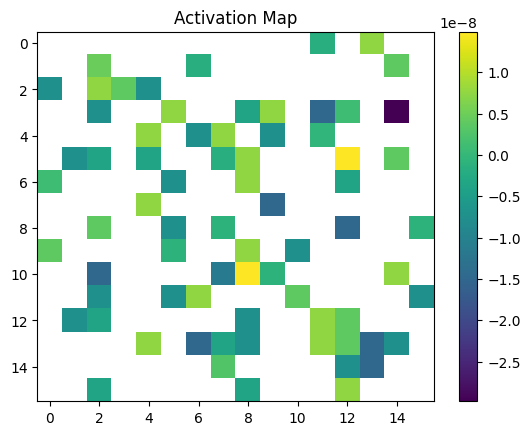

In [2]:
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#grayscale
def rgb_to_grayscale(images):
    return np.dot(images[..., :3], [0.2989, 0.587, 0.114])

x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

# Normalize
x_train_gray = x_train_gray / 255.0
x_test_gray = x_test_gray / 255.0
image_index = 1

input_image1 = np.expand_dims(x_test_gray[image_index], axis=0)

# print(input_image1)
input_image1.fill(0)
# Get the activations of the last Dense layer neurons
activations1 = model.predict(input_image1)
# print(f"Activations of the last Dense layer for the first test image: {activations1}")
# for i in range(32):
input_image1[0, 0, 1] = 1
# print(input_image1)
# input_image1.fill(0)
activations = model.predict(input_image1)
# print(f"Activations of the last Dense layer for the first test image: {activations}")
# print(activations1-activations)

# print(input_image1)
# activations = model.predict(input_image1)
# print(f"Activations of the last Dense layer for the first test image: {activations}")
def visualize_activations(activations):
    num_neurons = activations.shape[1]
    side_length = int(np.ceil(np.sqrt(num_neurons)))  # Determine the side length of the square

    activation_map = np.zeros((side_length, side_length))
    activation_map.flat[:num_neurons] = activations

    # Replace zero values with NaN for coloring
    activation_map[activation_map == 0] = np.nan

    # Create a colormap with black for NaN values
    cmap = plt.cm.viridis
    cmap.set_bad(color='white')

    # Plot the activation map
    plt.imshow(activation_map, cmap=cmap, aspect='auto')
    plt.colorbar()
    plt.title('Activation Map')
    plt.show()

activation_diff = activations1 - activations
visualize_activations(activation_diff)


1/1 [==============================] - 0s 21ms/step


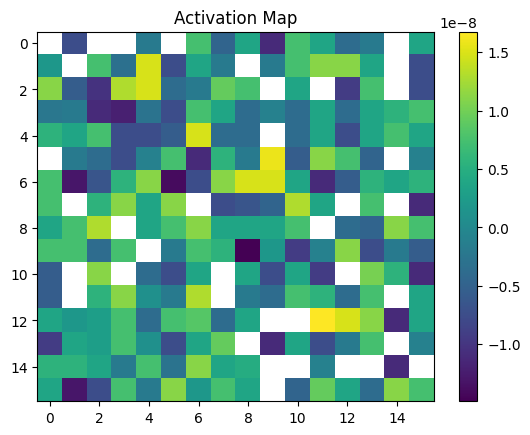

In [ ]:
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#grayscale
def rgb_to_grayscale(images):
    return np.dot(images[..., :3], [0.2989, 0.587, 0.114])

x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

# Normalize
x_train_gray = x_train_gray / 255.0
x_test_gray = x_test_gray / 255.0
image_index = 1

input_image1 = np.expand_dims(x_test_gray[image_index], axis=0)

# print(input_image1)
input_image1.fill(0)
# Get the activations of the last Dense layer neurons
activations1 = model.predict(input_image1)
# print(f"Activations of the last Dense layer for the first test image: {activations1}")
# for i in range(32):
# input_image1[0, 15, 31] = 1
# print(input_image1)
input_image1.fill(1)
activations = model.predict(input_image1)
# print(f"Activations of the last Dense layer for the first test image: {activations}")
# print(activations1-activations)

# print(input_image1)
# activations = model.predict(input_image1)
# print(f"Activations of the last Dense layer for the first test image: {activations}")
def visualize_activations(activations):
    num_neurons = activations.shape[1]
    side_length = int(np.ceil(np.sqrt(num_neurons)))  # Determine the side length of the square

    activation_map = np.zeros((side_length, side_length))
    activation_map.flat[:num_neurons] = activations

    # Replace zero values with NaN for coloring
    activation_map[activation_map == 0] = np.nan

    # Create a colormap with black for NaN values
    cmap = plt.cm.viridis
    cmap.set_bad(color='white')

    # Plot the activation map
    plt.imshow(activation_map, cmap=cmap, aspect='auto')
    plt.colorbar()
    plt.title('Activation Map')
    plt.show()

activation_diff = activations1 - activations
visualize_activations(activation_diff)


10 june


100%|██████████| 170498071/170498071 [00:02<00:00, 58264560.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1,  2000] loss: 1.970
[1,  4000] loss: 1.841
[1,  6000] loss: 1.766
[1,  8000] loss: 1.678
[1, 10000] loss: 1.630
[1, 12000] loss: 1.589
[2,  2000] loss: 1.506
[2,  4000] loss: 1.503
[2,  6000] loss: 1.517
[2,  8000] loss: 1.519
[2, 10000] loss: 1.474
[2, 12000] loss: 1.482
[3,  2000] loss: 1.428
[3,  4000] loss: 1.409
[3,  6000] loss: 1.469
[3,  8000] loss: 1.473
[3, 10000] loss: 1.493
[3, 12000] loss: 1.488
[4,  2000] loss: 1.432
[4,  4000] loss: 1.412
[4,  6000] loss: 1.431
[4,  8000] loss: 1.465
[4, 10000] loss: 1.478
[4, 12000] loss: 1.518
[5,  2000] loss: 1.378
[5,  4000] loss: 1.435
[5,  6000] loss: 1.448
[5,  8000] loss: 1.479
[5, 10000] loss: 1.490
[5, 12000] loss: 1.525
[6,  2000] loss: 1.422
[6,  4000] loss: 1.451
[6,  6000] loss: 1.484
[6,  8000] loss: 1.477
[6, 10000] loss: 1.482
[6, 12000] loss: 1.531
[7,  2000] loss: 1.448
[7,  4000] loss: 1.481
[7,  6000] loss: 1.508
[7,  8000] los

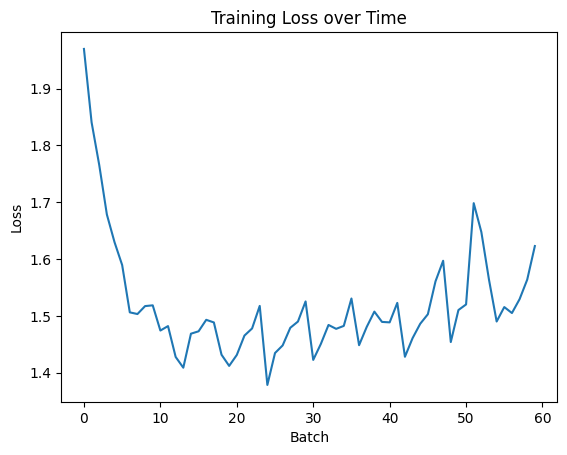

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# βLASSO optimizer definition
class βLASSO(optim.Optimizer):
    def __init__(self, params, lr=0.01, l1_lambda=0.009, beta=50.0):
        defaults = dict(lr=lr, l1_lambda=l1_lambda, beta=beta)
        super(βLASSO, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                l1_lambda = group['l1_lambda']
                beta = group['beta']
                lr = group['lr']

                update = lr * (grad + l1_lambda * grad.sign())
                mask = (p.abs() > beta * l1_lambda).float()
                p.data.add_(-update * mask)

        return loss

# Neural network definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Training the neural network
criterion = nn.CrossEntropyLoss()
optimizer = βLASSO(net.parameters(), lr=0.03, l1_lambda=0.005, beta=1.0)

losses = []

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')

# Visualize the training process
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()


In [ ]:
def compute_accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [ ]:
train_accuracy = compute_accuracy(net, trainloader)
test_accuracy = compute_accuracy(net, testloader)

print('Accuracy of the network on the 50,000 training images: %d %%' % train_accuracy)
print('Accuracy of the network on the 10,000 test images: %d %%' % test_accuracy)


Accuracy of the network on the 50,000 training images: 56 %
Accuracy of the network on the 10,000 test images: 47 %
